# Lab 1: Part C: Bayesian Approach
In this final part of the lab we will explore Bayesian parameter estimation. The ML and MAP solutions only give a point estimate of the parameters; whereas, the Bayesian approach gives a full distribution over the parameter space. Additionally, by using a conjugate prior we are guaranteed a closed form expression for this posterior distribution over the parameters. We still bruteforce the computation using the prior and likelihood though for comparison.

In [13]:
%load_ext autoreload
%autoreload 2

# For matrices
import numpy as np

# For plotting
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('font', size=15)

# Our custom modules
from normal import *
from log_normal import *
from normal_inv_gamma import *
from plot_normal import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Generate some data points from a normal distribution
mu = 1     # mean
sigma = 2  # standard deviation = sqrt(variance)
N = 1      # number of datapoints

X = mu + sigma*np.random.randn(N,1)

In [15]:
# hyperparameters for prior - normal inverse gamma
alpha = 1
beta = 1
gamma = 1
delta = 0

## Parameters for posterior

### TODO 1
Define the parameters for the Bayesian posterior. Consult lecture notes.

In [16]:
gammaP = gamma + N
deltaP = (gamma * delta + np.sum(X)) / (gamma + N)
alphaP = alpha + N / 2
betaP = (np.sum([i**2 for i in X]) / 2 + beta + delta ** 2 * gamma / 2 - 
         (gamma * delta + np.sum(X)) ** 2 / (2 * gamma + 2 * N))

## ML + MAP parameter estimation of univariate normal

While we calculate the conjugate prior we are also going to brute force the posterior for some nice plots.

### TODO 2
Fill these equations from the previous section `prac1_b`.

In [17]:
muMAP = (np.sum(X) + gamma * delta) / (len(X) + gamma)
sigmaMAP = np.sqrt((np.sum([((xi - muMAP) ** 2) for xi in X]) + 2.0 * beta + gamma * ((delta - muMAP) ** 2)) / (len(X) + 3 + 2 * alpha))
muML = np.average(X)
sigmaML = np.sqrt(np.sum([(i - muML) ** 2 / len(X) for i in X]))

Estimated ML Mean: 0.85
Estimated ML Standard Deviation: 0.00

Estimated MAP Mean: 0.43
Estimated MAP Standard Deviation: 0.63


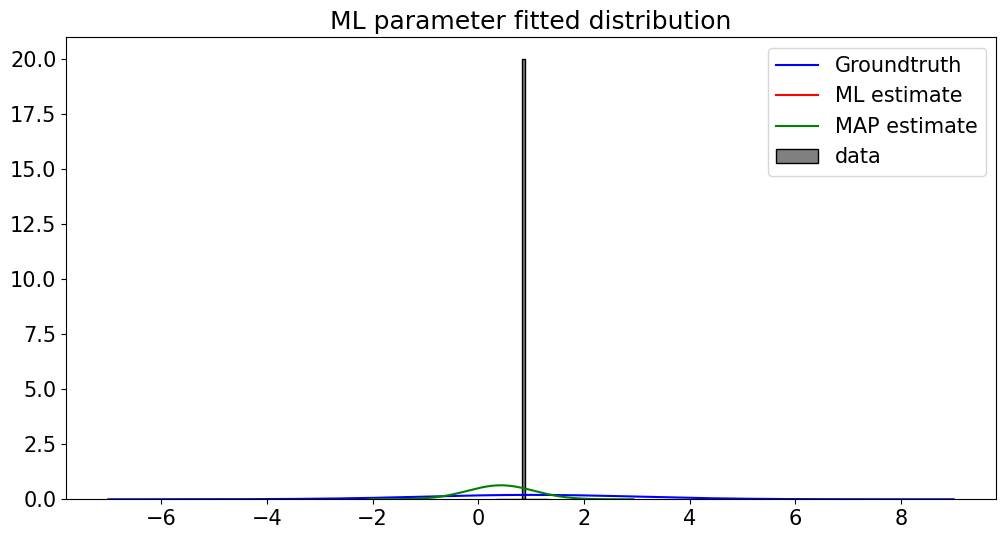

In [18]:
print("Estimated ML Mean: " + "{:.2f}".format(muML))
print("Estimated ML Standard Deviation: " + "{:.2f}".format(sigmaML))
print("")
print("Estimated MAP Mean: " + "{:.2f}".format(muMAP))
print("Estimated MAP Standard Deviation: " + "{:.2f}".format(sigmaMAP))

# Plotting univariate normal
# Normalizing histograms - assuming bins are evenly sized
[hist_count, bin_edges] = np.histogram(X, 20)
bin_width = bin_edges[1] - bin_edges[0]
hist_pos = (bin_edges[1:] + bin_edges[:-1]) / 2.

# Plot figure
plt.bar(bin_edges[:-1], hist_count/(np.sum(hist_count)*bin_width), color='gray', 
        edgecolor='k', width=bin_width, label='data')
plot_normal(mu, sigma, 'b', 'Groundtruth')
plot_normal(muML, sigmaML, 'r', 'ML estimate')
plot_normal(muMAP, sigmaMAP, 'g', 'MAP estimate')
plt.legend()
plt.title('ML parameter fitted distribution')
plt.show()

## Likelihood function
We will loop over some possible values of parameters that our distribution can have and compute the posterior using two ways. We'll calculate the prior and likelihood like we did in `prac1_b.ipynb` and then use a closed form expression that you can find in the lecture notes. 

In [19]:
sigma_range = np.linspace(0.02, 2., num=200)
mu_range = np.linspace(-2., 2., num=400)

conj_posterior = np.zeros((len(sigma_range), len(mu_range)))
lfun = np.zeros((len(sigma_range), len(mu_range)))
prior = np.zeros((len(sigma_range), len(mu_range)))

for i, m in enumerate(mu_range):
    for j, s in enumerate(sigma_range):
        
        # here we are just brute forcing for the posterior (as before)
        lfun[j,i] = normal(X, m, s)
        prior[j,i] = normal_inv_gamma(alpha, beta, delta, gamma, m, s)
        
        # TODO 3 - Compute the posterior given the new closed form expression, consult lecture notes, 
        # this is our closed form solution
        
        conj_posterior[j,i] = normal_inv_gamma(alphaP, betaP, deltaP, gammaP, m, s)

### TODO 4
Estimate the posterior (brute force way). Bayes Rule... 

In [20]:
posterior = np.zeros((len(sigma_range), len(mu_range)))
for i, m in enumerate(mu_range):
    for j, s in enumerate(sigma_range):
        posterior[j][i] = lfun[j,i] * prior[j,i]

### TODO 5
Look at the plots and verify that the peak of this distribution again corresponds to the MAP solution. You'll see two plots, the closed form expression from the slides using `conj_posterior` and the posterior calculation we've done before. Note how with both the ML and MAP estimations, we only get one set of $\mu$ and $\sigma$, while the Bayes estimate gives us a family of possible solutions and the probability of them being accurate given the data.

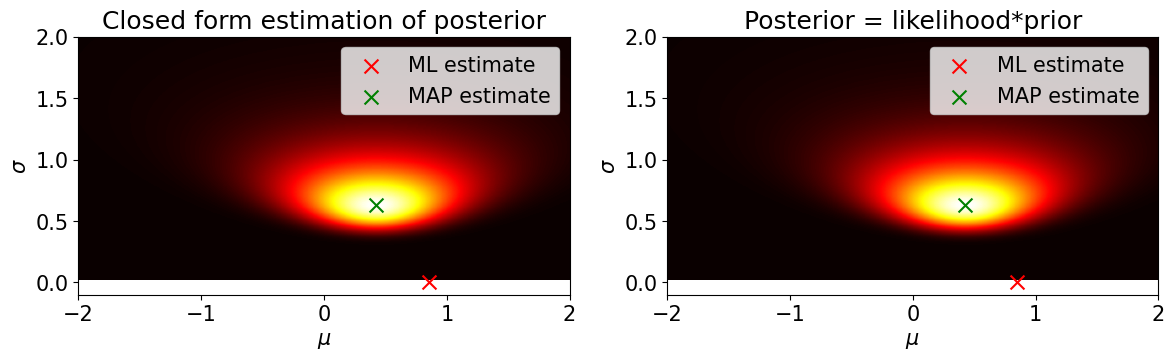

In [21]:
# Plot posterior
plt.subplot(1,2,1)
plt.imshow(conj_posterior, cmap="hot", origin="lower", 
           extent=[mu_range[0], mu_range[-1], sigma_range[0], sigma_range[-1]])
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.title("Closed form estimation of posterior")

## Plot points
plt.scatter(muML, sigmaML, color='r', marker='x', s=100, label='ML estimate')
plt.scatter(muMAP, sigmaMAP, color='g', marker='x', s=100, label='MAP estimate')
plt.legend()


# Plot posterior
plt.subplot(1,2,2)
plt.imshow(posterior, cmap="hot", origin="lower", 
           extent=[mu_range[0], mu_range[-1], sigma_range[0], sigma_range[-1]])
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.title("Posterior = likelihood*prior")

## Plot points
plt.scatter(muML, sigmaML, color='r', marker='x', s=100, label='ML estimate')
plt.scatter(muMAP, sigmaMAP, color='g', marker='x', s=100, label='MAP estimate')
plt.legend()

plt.tight_layout()

### BONUS TODO 6
Write code to estimate the probability that a new data point belongs to the same model. Compare the ML, MAP and fully Bayesian methods to do this. What are the advantages of using the Bayesian approach?

In [22]:
def get_pr_bayesian(data):
    alphaN = alphaP + 0.5
    gammaN = gammaP + 1
    betaN = data**2 / 2 + betaP + deltaP ** 2 * gammaP / 2 - (gammaP * deltaP + data)**2 / (2*(gammaP + 1))
    pr = 1/np.sqrt(2*np.pi) * np.sqrt(gammaP / gammaN) * np.power(betaP, alphaP) / np.power(betaN, alphaN) * gamma_function(alphaN) / gamma_function(alphaP)
    return pr
def get_pr_ml(data):
    return normal([data], muML, sigmaML)
def get_pr_map(data):
    return normal([data], muMAP, sigmaMAP)

In [23]:
data = np.linspace(-5, 5, 100)
pr_bayesian = [get_pr_bayesian(i) for i in data]
pr_ML = [get_pr_ml(i) for i in data]
pr_map = [get_pr_map(i) for i in data]

D:\Document\Study\Term 1\COMP0137 Machine Vision\Pratical 1\01_FittingProbDistribs\normal.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  likelihoods = [1 / np.sqrt(2 * np.pi * (sigma ** 2)) * np.exp(-0.5 * ((xi - mu) ** 2) / (sigma ** 2)) for xi in X]
D:\Document\Study\Term 1\COMP0137 Machine Vision\Pratical 1\01_FittingProbDistribs\normal.py:17: RuntimeWarning: invalid value encountered in scalar multiply
  likelihoods = [1 / np.sqrt(2 * np.pi * (sigma ** 2)) * np.exp(-0.5 * ((xi - mu) ** 2) / (sigma ** 2)) for xi in X]


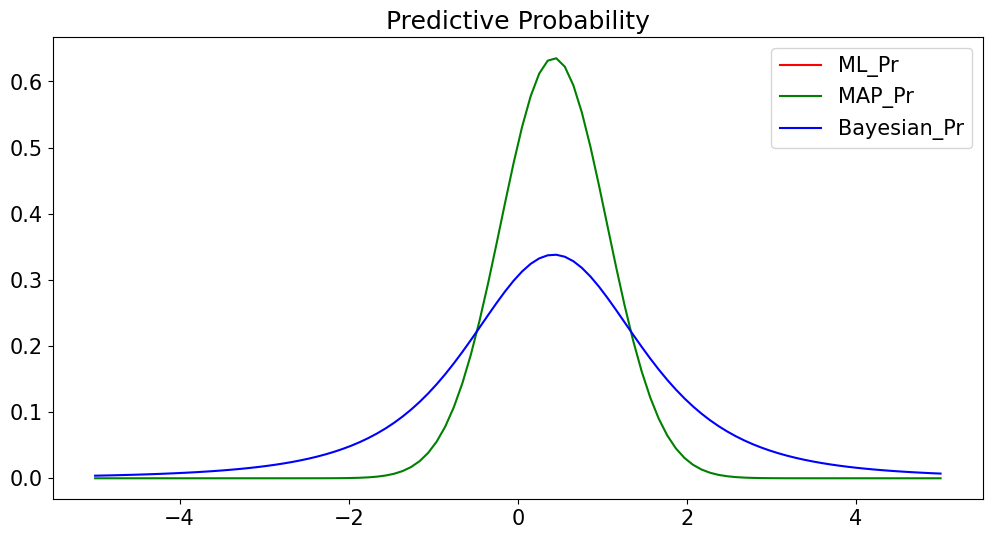

In [24]:
plt.plot(data, pr_ML, 'r', label='ML_Pr')
plt.plot(data, pr_map, 'g', label='MAP_Pr')
plt.plot(data, pr_bayesian, 'b', label='Bayesian_Pr')
plt.legend()
plt.title('Predictive Probability')
plt.show()